<h2>Imports and Globals</h2>

In [2]:
%matplotlib inline

In [198]:
from __future__ import absolute_import
import os
import random
import re

from sklearn import tree
from sklearn.cross_decomposition import CCA
from sklearn.cross_validation import cross_val_score, train_test_split

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


DATA_DIR = '/Users/emiwang/Learning/notebooks/medpred/data/'
BASE_FILE = 'meps_base_data.csv'
MEDS_FILE = 'meps_meds.csv'

plt.style.use('ggplot')

<h2>Methods for data cleaning and getting disease/meds stats</h2>

In [177]:
def clean_rxname(rxname):
    """Make string substitutions to dedupe rxnames.
    
    After looking at various drug name families to understand 
    common duping situations, decided on these substitutions.  
    Full details of exploration in Diseases notebook.
    
    -Remove all parenthetical statements, as they tend to be commentary.
    -Remove all statements after a comma, for same reason as above.
    -Remove HCL and HYDROCHLORIDE groups since this is a salt group suffix.
    -Replace ' AND ', '/', ' & ' with '-'.
    -Truncate trailing ' TABLET', ' TAB' unit commentary.
    -Strip trailing and leading spaces.

    """
    replacements = [
        ('\([\w\s\D]+\)', ''),
        (',[\w\s\D]+', ''),
        ('\([-,/\w^\)]+\Z',''),  
        (' HCL', ''),
        (' HYDROCHLORIDE', ''),
        (' AND ', '-'),
        (' & ', '-'),
        ('/', '-'),
        (' TABLET\Z', ''),
        (' TAB\Z', '')
    ]
    for pattern in replacements:
        rxname = re.sub(pattern[0], pattern[1], rxname)
    rxname = rxname.rstrip().lstrip()
    return rxname


def get_disease_stats(disease_med_counts, disease, top_n=10,
                      print_stats=True):
    """Get medication stats for a given disease diagnosis."""
    
    counts = disease_med_counts[disease]
    matched = re.match('^([\w]+)Diagnosed_Yes', disease)
    disease_edit = matched.group(1)
    sorted_counts = sorted(counts.items(), key = itemgetter(1), reverse=True)
    top_disease_meds = pd.DataFrame(sorted_counts, columns=['med', 'med_counts'])
    total_counts = float(top_disease_meds.med_counts.sum())
    top_disease_meds['percent'] = 100 * top_disease_meds.med_counts.astype(float) / total_counts
    top_disease_meds['percent'] = [round(i, 2) for i in top_disease_meds.percent]
    
    leaders = top_disease_meds[0:top_n]
    if print_stats:
        print '\n{} medications:'.format(disease_edit)
        print leaders
    return leaders


def get_top_rxnames(disease_med_counts, top_n=10, print_stats=True):
    """Get top_n meds for each disease, union and dedupe into one list."""
    
    top_rxnames = []
    for disease in disease_med_counts.iterkeys():
        top_disease_meds = get_disease_stats(disease_med_counts, disease,
                                             top_n=top_n, print_stats=print_stats)
    
        rxname_list = list(top_disease_meds.med)
        top_rxnames = top_rxnames + rxname_list 
    top_rxnames = list(set(top_rxnames))
    
    return top_rxnames

<h2>Methods for further data processing and decision tree</h2>

In [69]:
def process_inputs(meds_data):
    """Dedupe medication names from raw file using clean_rxname().
    
    Used for decision tree model."""
    
    meds_copy = meds_data.copy(deep=True)
    meds_copy = meds_copy.drop('Unnamed: 0', 1)
    rxnames = meds_copy.rxName
    rxnames_clean = [clean_rxname(i) for i in rxnames]
    meds_copy['rxName'] = rxnames_clean
    
    # Only count one instance of each medication per patient id.
    meds_copy = meds_copy.drop_duplicates(subset=['id','rxName'])
    
    return meds_copy


def process_outputs(base_data):
    """Process base data in preparation for getting single yes diagnoses.
    
    Used for decision tree model.  Select id and diagnosis columns, 
    make ones column for easy counting, and binary-ify the diagnoses.  
    
    """
    base_copy = base_data.copy(deep=True)
    diagnosis_cols = [i for i in base_copy.columns if 'Diagnosed' in i]
    subset_cols = ['id'] + diagnosis_cols
    base_copy = base_copy[subset_cols]
    base_copy['entry_count'] = 1
    base_cats = pd.get_dummies(base_copy)
    
    return base_cats


def match_input_output(meds_input, output, output_list=[]):
    """Return medication data with 1/0 diagnosis flags for each patient."""
    
    if not len(output_list):
        output_list = [i for i in output.columns if 'Diagnosed' in i]
        
    output_cols = ['id'] + output_list
    
    # Merge medication data with diagnosis data on patient id.
    all_data = pd.merge(meds_input, output[output_cols], on='id', how='outer')
    all_data = all_data.fillna(0)
    
    # Consolidate all patient medication info into one row per ['id', outputs].
    grouped_data = all_data.groupby(output_cols, as_index=False).sum()
    return grouped_data


def make_output_binary(data_df):
    """Turn any diagnosis that is not a Yes or No into the most common value."""
    
    df = data_df.copy(deep=True)
    diagnoses = [i for i in df.columns if 'Diagnosed' in i]
    
    # Iterate over every disease column.
    for diagnosis in diagnoses:
        
        all_labels = list(output[diagnosis].unique())
        binary_labels = ['Yes', 'No']
        non_binary_labels = [i for i in all_labels if i not in binary_labels]
        
        # Obtaining the label mode
        binary_labeled = df[df[diagnosis].isin(binary_labels)]
        diagnosis_mode = binary_labeled[diagnosis].mode()[0]
        
        # Replacing non binary labels with the mode.
        for class_label in non_binary_labels:
            df[diagnosis] = df[diagnosis].replace(class_label, diagnosis_mode)
                    
    df = df.replace('Yes', 1)
    df = df.replace('No', 0)
    
    return df


def make_x_and_y(all_outputs_data):
    """Pull out X (meds) and Y (diagnoses) arrays."""
    y_cols = [i for i in all_outputs_data.columns if 'Diagnosed' in i]
    x_cols = [i for i in all_outputs_data.columns if i not in y_cols and i != 'id']
    X = all_outputs_data[x_cols]
    Y = all_outputs_data[y_cols]
    
    return X, Y


def fit_tree(X, Y, test_size=0.2, random_state=137):
    """Fit a decision tree with a holdout test group of fraction test_size."""
    
    X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, test_size=test_size, random_state=random_state
    )

    clf = tree.DecisionTreeClassifier()
    clf = clf.fit(X_train, Y_train)

    print 'Num features: {}\nNum outputs: {}\nNum classes: {}'.format(clf.n_features_, clf.n_outputs_, clf.n_classes_)
    print 'Train set accuracy: {:.3}'.format(clf.score(X_train, Y_train))
    print 'Test set accuracy: {:.3}'.format(clf.score(X_test, Y_test))
    print 'Classes: {}'.format(list(clf.classes_))
    
    return clf

In [5]:
# Example of cleaning medication name
clean_rxname(' HYDROCHLOROTHIAZIDE AND MEEP & RAINBOW/CHARMS (FILM-COATED 22 MG)')

'HYDROCHLOROTHIAZIDE-MEEP-RAINBOW-CHARMS'

<h2>Exploring the datasets</h2>

In [6]:
base_data = pd.read_csv(os.path.join(DATA_DIR, BASE_FILE))
meds_data = pd.read_csv(os.path.join(DATA_DIR, MEDS_FILE))

<h3>Base data</h3>

In [7]:
# There are ages of -1?  No data?
base_data[['panel', 'pooledWeight', 'age']].describe()

,panel,pooledWeight,age
count,61489.000000,61489.000000,61489.000000
mean,13.534453,5063.701982,33.578396
std,1.061329,3815.885387,22.887576
min,12.000000,127.710358,-1.000000
25%,13.000000,2217.419038,14.000000
50%,14.000000,3989.180418,32.000000
75%,14.000000,6905.677619,51.000000
max,15.000000,38828.153564,85.000000


In [9]:
len(base_data), len(base_data.drop_duplicates())  # No completely duplicate entries

(61489, 61489)

In [8]:
# Remove the unnamed index, id, and panel columns
subset_cols = [i for i in base_data.columns if i not in ('Unnamed: 0', 'id', 'panel')]

# Percent duplicate patient data: less than 1% are duplicated.
# This could be actual duplicates or patients who happen to have the exact same stats.  
# Do nothing for nows ince there are so few duplicates.
100 * float(len(base_data) - len(base_data.drop_duplicates(subset=subset_cols))) / len(base_data)

0.28297744311990763

In [9]:
subset_base_data = base_data.copy(deep=True)
subset_base_data = subset_base_data[subset_cols]
subset_base_data['entry_count'] = 1

In [10]:
dupe_count = subset_base_data.groupby(subset_cols).count()
# dupe_count[dupe_count.entry_count > 1].head()

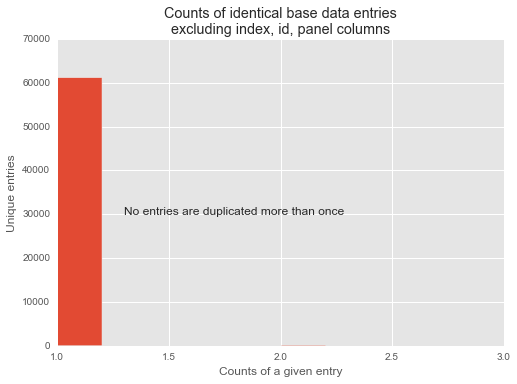

In [11]:
dupe_count.entry_count.hist(bins=10)
plt.title('Counts of identical base data entries\nexcluding index, id, panel columns')
plt.xlabel('Counts of a given entry')
plt.ylabel('Unique entries')
plt.text(1.3, 30000, 'No entries are duplicated more than once', fontsize=12)

In [12]:
base_copy = base_data.copy(deep=True)
base_copy = base_copy.drop('Unnamed: 0', 1)

<h3>Frequencies of categorical disease outputs</h3>

Below, we see that some are fairly balanced between Yes and No, while others are quite unbalanced (e.g. emphysema and heart failure).

In [13]:
base_copy['entry_count'] = 1
cat_cols = [i for i in base_data.columns if i not in ('Unnamed: 0', 'id', 'panel', 'age', 'pooledWeight', 'sex', 'race', 'married')]
for column in cat_cols:
    print base_copy.groupby(column).count()[['entry_count']]

                 entry_count
highBPDiagnosed             
DK                        48
Inapplicable           18270
No                     29525
Refused                    4
Yes                    13637
not ascertained            5
                   entry_count
diabetesDiagnosed             
DK                          19
Inapplicable             18270
No                       38848
Refused                      5
Yes                       4340
not ascertained              7
                 entry_count
chdDiagnosed                
DK                        36
Inapplicable           18270
No                     40844
Refused                    4
Yes                     2328
not ascertained            7
                 entry_count
miDiagnosed                 
DK                        22
Inapplicable           18270
No                     41658
Refused                    5
Yes                     1527
not ascertained            7
                 entry_count
anginaDiagnosed            

<h3>Prescribed meds data</h3>

In [14]:
meds_data.describe()  # Missing start month and start year represented as negative numbers?

,Unnamed: 0,id,rxStartMonth,rxStartYear,rxNDC,rxQuantity
count,1.148347e+06,1.148347e+06,1.148347e+06,1.148347e+06,1.148347e+06,1.148347e+06
mean,1.240252e+06,5.523596e+07,5.184600e-01,1.172427e+03,2.226109e+10,5.942380e+01
std,9.590400e+05,2.728584e+07,4.087907e+00,9.895660e+02,2.834269e+10,3.702845e+02
min,1.000000e+00,1.000710e+07,-9.000000e+00,-1.400000e+01,-9.000000e+00,-9.000000e+00
25%,2.870875e+05,4.063810e+07,-1.000000e+00,-1.000000e+00,1.490472e+08,3.000000e+01
50%,1.093262e+06,4.947510e+07,-1.000000e+00,2.000000e+03,5.910385e+08,3.000000e+01
75%,2.103602e+06,8.118210e+07,1.000000e+00,2.008000e+03,5.486835e+10,6.800000e+01
max,3.336212e+06,8.968810e+07,1.200000e+01,2.011000e+03,9.920707e+10,1.200000e+05


In [15]:
meds_data.head()

,Unnamed: 0,id,rxStartMonth,rxStartYear,rxName,rxNDC,rxQuantity,rxForm
0,1,10007104,3,2011,AMOXICILLIN,143988775,75.0,SUSR
1,2,10007104,3,2011,OTIC EDGE SOLUTION,68032032814,14.0,SOL
2,3,10008102,3,2011,NASAL DECONGESTANT 0.05% SPRAY,63981056903,15.0,SPR
3,4,10008102,3,2011,NASAL DECONGESTANT 0.05% SPRAY,63981056903,15.0,SPR
4,5,10008102,9,2011,DIPHENHYDRAM,603333921,30.0,CAP


In [16]:
len(meds_data), len(meds_data.drop_duplicates())  # Also no completely duplicate rows here

(1148347, 1148347)

<h2>Most common medications for each disease</h2>

<i>Approach</i>: Get all patients who only have one diagnosis.  Group them by disease and count up all the different medications.  For each disease, get the top 10 medications.

Some considerations:
    
- Even with selecting people diagnosed with just one disease, we could be missing diagnosis data for other diseases.  Or a doctor might prescribe corresponding medication just in case?  High blood pressure can apparently lead to diabetes:
http://www.webmd.com/hypertension-high-blood-pressure/guide/high-blood-pressure

- People could have multuple Rx entries for the same drug.  We want to only count one per patient when getting frequencies.

- We have only done rudimentary deduping, related to string formatting and extra comments.  More deduping could be done if we had a repository of the multiple names different drugs can take.  Some quick googling reveals most drugs have generic and brand names.

If we dummyify all of the prescriptions, even after some deduping, pandas is going to be very sad with that many columns.  I think we're going to have to rely on good old defaultdict iteration!  

Make an empty default dict whose keys are the user id.

In [17]:
from collections import defaultdict, Counter
from operator import itemgetter

In [18]:
meds_copy = process_inputs(meds_data)

In [19]:
base_cats = process_outputs(base_data)
yes_cols = [i for i in base_cats.columns if 'Yes' in i]
yes_cols = ['id'] + yes_cols
base_cats = base_cats[yes_cols]

In [20]:
meds_name = meds_copy[['id', 'rxName']]
merged = pd.merge(base_cats, meds_name, on='id')

In [21]:
merged_list = merged.to_dict(orient='record')

In [22]:
patient_meds = defaultdict(Counter)
for entry in merged_list:
    # We need to update all of the diagnoses
    # And we need to turn all of the rxNames into their own entries.
    diagnoses = Counter({key:value for key, value in entry.iteritems() if 'Yes' in key})
    patient_id = entry['id']
    rxname = entry['rxName']
    patient_meds[patient_id][rxname] = 1
    patient_meds[patient_id]['id'] = patient_id
    patient_meds[patient_id].update(diagnoses)

# Turn the whole thing into a dict so we don't accidentally add more keys.
patient_meds = dict(patient_meds)

In [23]:
# The diagnoses will get repeated so we have to figure out how many are just one diagnosis.  
single_yes_diagnoses = []
for entry in patient_meds.itervalues():
    num_diagnoses = 0
    disease = None
    for key, yes_count in entry.iteritems():
        if 'Yes' in key and yes_count != 0:
            num_diagnoses += 1
            disease = key
    if num_diagnoses == 1:
        entry['disease'] = disease
        single_yes_diagnoses.append(entry)
single_yes_diagnoses = [dict(i) for i in single_yes_diagnoses]

In [24]:
len(single_yes_diagnoses), len(patient_meds)  # About 25% of all patients are single diagnoses

(10926, 41783)

In [25]:
# For all single_yes_diagnoses, sort it into a defaultdict that is keyed by disease and 
# has dicts that count up every prescription.
disease_med_counts = defaultdict(dict)
for patient in single_yes_diagnoses:
    disease = patient['disease']
    medicines = [i for i in patient.keys() if i not in ('disease', 'id') and '_Yes' not in i]
    for med in medicines:
        # Increment the med count if the med already exists.
        # Otherwise initialize the count for the med.
        if disease_med_counts[disease].get(med, None):
            disease_med_counts[disease][med] += 1
        else:
            disease_med_counts[disease][med] = 1
disease_med_counts = dict(disease_med_counts)

Below are the top 10 medications seen in a given disease.  Some of the sample sizes are rather small, so we may not have a clear signal. Sample sizes are small because we've restricted it to people who have only one diagnosis, to avoid the issue of disease correlations.  Note also that the top 10 medications each comprise a small percent of total medications (none are greater than ~5%), which suggests a long tail of medications.  We probably still have a lot of alternate names for the same medications.

Expanded disease names from google:

mi = Myocardial Infarction (heart attack)

chd = Coronary Heart Disease

other hd = Other heart disease

As a first simple cut, let's save the list of top_rxnames and first use only these as a simple way to reduce the dimensionality of our feature space.

In [38]:
top_rxnames = get_top_rxnames(disease_med_counts, top_n=10, 
                              print_stats=True)


mi medications:
                       med  med_counts  percent
0             HYDROCO-APAP           7     2.45
1              SIMVASTATIN           6     2.10
2               LISINOPRIL           5     1.75
3             AZITHROMYCIN           5     1.75
4                  LIPITOR           5     1.75
5                   PLAVIX           5     1.75
6      METOPROLOL TARTRATE           4     1.40
7             PANTOPRAZOLE           4     1.40
8               FUROSEMIDE           4     1.40
9  METOPROLOL SUCCINATE ER           4     1.40

stroke medications:
            med  med_counts  percent
0   SIMVASTATIN          24     2.96
1  AZITHROMYCIN          22     2.72
2   AMOXICILLIN          17     2.10
3     IBUPROFEN          14     1.73
4  HYDROCO-APAP          11     1.36
5       LIPITOR          10     1.23
6  LEVOTHYROXIN           9     1.11
7    GABAPENTIN           8     0.99
8    PREDNISONE           7     0.86
9    FLUOXETINE           6     0.74

emphysema medications:
   

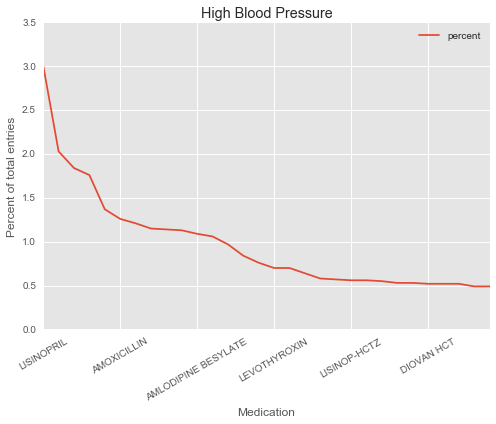

In [50]:
rxname_count_highbp = get_disease_stats(disease_med_counts, disease='highBPDiagnosed_Yes',
                                        top_n=30, print_stats=False)
sorted_bp = rxname_count_highbp.sort_values(by='med_counts', ascending=False)
sorted_bp.plot(x='med', y='percent', rot=30)
plt.ylabel('Percent of total entries')
plt.xlabel('Medication')
plt.title('High Blood Pressure')

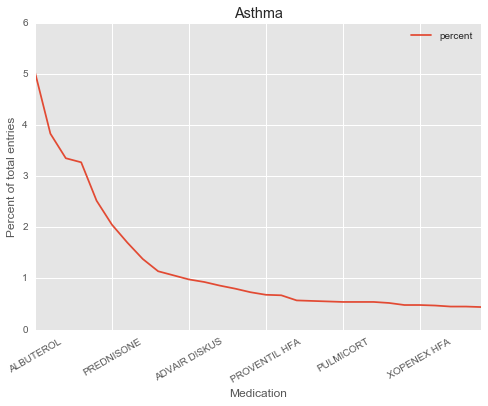

In [51]:
rxname_count_ast = get_disease_stats(disease_med_counts, disease='asthmaDiagnosed_Yes',
                                        top_n=30, print_stats=False)
sorted_ast = rxname_count_ast.sort_values(by='med_counts', ascending=False)
sorted_ast.plot(x='med', y='percent', rot=30)
plt.ylabel('Percent of total entries')
plt.xlabel('Medication')
plt.title('Asthma')

<h2>Medications are most indicative of each disease</h2>

<i>Approach</i>: Compute Pearson correlation coefficient for each medication against each possible disease.  This coefficient consists of the covariance between two variables divided by the product of each variable's standard deviation, and looks for a linear relationship between the given two variables (so this won't detect all types of correlation).  A coefficient of 1 means they are perfectly positively correlated, while a value of -1 means that they are perfectly negatively correlated.

Limit our independent variables to the unioned and deduped most prevalent medications for each disease, which is 71 medications total.

<h3>Preparing the data</h3>

In [98]:
top_rxnames = get_top_rxnames(disease_med_counts, top_n=15, print_stats=False)

In [99]:
len(top_rxnames) # Number of input variables

71

In [100]:
meds_input = meds_copy.copy(deep=True)

In [101]:
meds_input = meds_input[meds_input.rxName.isin(top_rxnames)]  # Filter for top rxnames and then drop dupes
meds_input = meds_input[['id','rxName']]
meds_input = meds_input.drop_duplicates()

In [102]:
rxname_dummies = pd.get_dummies(meds_input.rxName)  # make rxname classes have binary 1/0 values
meds_input = pd.merge(meds_input[['id']], rxname_dummies, left_index=True, right_index=True)  # tack the ids back on

In [103]:
output = base_data.copy(deep=True)
diagnoses = [i for i in output.columns if 'Diagnosed' in i]
diagnoses_cols = ['id'] + diagnoses

In [104]:
output = output[diagnoses_cols]

In [105]:
list(output.chdDiagnosed.unique())

['No', 'Inapplicable', 'Yes', 'DK', 'not ascertained', 'Refused']

In [201]:
all_outputs_data = match_input_output(meds_input, output, output_list=[])
all_outputs_data = make_output_binary(all_outputs_data)
# Sweet there are no conflicting diagnoses
len(all_outputs_data.id.unique()), len(all_outputs_data)

(61489, 61489)

In [202]:
X, Y = make_x_and_y(all_outputs_data)

<h3>Get the correlations</h3>

In [219]:
all_corr = []
for med in X.columns:
    x_arr = np.array(X[med])
    for disease in Y.columns:
        y_arr = np.array(Y[disease])
        cc = np.corrcoef(x_arr, y_arr)
        one_entry = {
            'med': med,
            'disease': disease,
            'corrcoef': round(cc[0,1], 3),
        }
        all_corr.append(one_entry)
all_corr_df = pd.DataFrame(all_corr)

Below, for each disease we show the top 10 correlated medications, or the medications that are most indicative of that given disease.

In [235]:
for disease in list(all_corr_df.disease.unique()):
    subset = all_corr_df[all_corr_df.disease == disease]
    subset = subset.sort_values(by='corrcoef', ascending=False)[0:10]
    print subset[['disease', 'med', 'corrcoef']]

             disease                  med  corrcoef
410  highBPDiagnosed           LISINOPRIL     0.379
620  highBPDiagnosed          SIMVASTATIN     0.283
310  highBPDiagnosed  HYDROCHLOROTHIAZIDE     0.271
440  highBPDiagnosed            METFORMIN     0.243
130  highBPDiagnosed             ATENOLOL     0.241
70   highBPDiagnosed           AMLODIPINE     0.240
80   highBPDiagnosed  AMLODIPINE BESYLATE     0.238
300  highBPDiagnosed         HYDROCHLOROT     0.225
250  highBPDiagnosed           FUROSEMIDE     0.223
390  highBPDiagnosed              LIPITOR     0.206
               disease           med  corrcoef
441  diabetesDiagnosed     METFORMIN     0.619
271  diabetesDiagnosed     GLIPIZIDE     0.343
531  diabetesDiagnosed      ONETOUCH     0.337
1    diabetesDiagnosed         ACTOS     0.333
291  diabetesDiagnosed     HUMULIN N     0.303
281  diabetesDiagnosed     GLYBURIDE     0.303
351  diabetesDiagnosed        LANTUS     0.301
511  diabetesDiagnosed     NOVOLIN N     0.290
341  

<h2>Creating a model to predict disease state</h2>

We want to take as input the medications prescribed and give as output what diseases a patient has.  This is a multi-output classification problem, since patients may have more than one disease.  We can approach this as a set of binary classification problems where we implement a one-vs-all strategy, or we can choose a model that does not require a problem transformation, such as a decision tree, random forest, or kNN.

I will go with a decision tree.  Decision trees are a model that can handle categorical variables, multiple labels per sample, and can also compute human-interpretable feature importances.  Making label decisions by splitting on features is also easy to understand.  Decisions trees don't perform well with unbalanced classes, so it would be best if we rebalanced the disease classes that have a big difference between numbers of Yeses and Nos.  We could do this by undersampling the majority class label.

- First take the top 10 medications for Yes in all the categories
- Keep all the different classes for diagnoses
- Make a decision tree!

If I had more time I would compare the results of using Multiple Correspondance Analysis (MCA) with Canonical Correlation Analysis to reduce dimensionality.  MCA is the categorical variable equivalent of PCA, which transforms variables that are correlated into new feature eigenvectors.

<h3>Getting a decision tree working, first with just one output: highBPDiagnosed</h3>

In [191]:
binary_output = make_output_binary(output)

In [193]:
bp_data = match_input_output(meds_input, output,
                             output_list=['highBPDiagnosed'])

In [195]:
len(bp_data.id.unique()), len(bp_data)  # No conflicting diagnoses

(61489, 61489)

Accuracy not great even on training set with only one output (67%).  As expected, somewhat lower accuracy for holdout/test set (60%).

In [189]:
x_cols = [i for i in bp_data.columns if i != 'id' and i != 'highBPDiagnosed']
X = bp_data[x_cols]
Y = bp_data[['highBPDiagnosed']]
clf = fit_tree(X, Y, test_size=0.2, random_state=223)

Num features: 71
Num outputs: 1
Num classes: 6
Train set accuracy: 0.672
Test set accuracy: 0.601
Classes: ['DK', 'Inapplicable', 'No', 'Refused', 'Yes', 'not ascertained']


In [114]:
sorted(set(Y_predict))  # It didn't predict any Refused or not ascertained, 
                        # probably because they are so rare.

['DK', 'Inapplicable', 'No', 'Yes']

Let's try only using the Yes and No data and fill in the other labels with the mode

In [111]:
x_cols = [i for i in bp_data.columns if i != 'id' and i != 'highBPDiagnosed']

# Turn all non Yes and No things into mode
diagnosis_mode = bp_data[bp_data.highBPDiagnosed.isin(('Yes', 'No'))].highBPDiagnosed.mode()[0]
diagnosis_classes = list(bp_data.highBPDiagnosed.unique())
non_binary = [i for i in diagnosis_classes if i not in ('Yes', 'No')]
bp_binary = bp_data.copy(deep=True)

for class_label in non_binary:
    bp_binary = bp_binary.replace(class_label, diagnosis_mode)

X = bp_binary[x_cols]
Y = bp_binary[['highBPDiagnosed']]
clf_bp = fit_tree(X, Y, test_size=0.2, random_state=211)

Num features: 71
Num outputs: 1
Num classes: 2
Train set accuracy: 0.916
Test set accuracy: 0.866
Classes: ['No', 'Yes']


Accuracy is a lot higher now: 92% for training and 87% for testing.  But we are assuming the non-binary decisions are the same as the mode, for simplicity.  With more time, I would try some undersampling of the mode labels, since some of the category labels are quite unbalanced between Yes and No.

Below, we see that precision is pretty good for both Nos and Yeses (87% and 80% respectively) but low recall for Yeses (51%).

In [112]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=211
)
Y_test_predict = clf_bp.predict(X_test)

# By default returns label stats in alphabetical order of labels.
precision, recall, fscore, support = precision_recall_fscore_support(Y_test, Y_test_predict) 
classes = sorted(list(clf_bp.classes_))

print 'Classes: {}'.format(classes)
print 'Precision: {}\nRecall: {}\nFscore: {}\nSupport: {}'.format(precision, recall, fscore, support)

Classes: ['No', 'Yes']
Precision: [ 0.87831142  0.79545455]
Recall: [ 0.96150636  0.52912979]
Fscore: [ 0.91802789  0.63551816]
Support: [9586 2712]


<h2>Decision tree final multi-output model</h2>

Now using the 71 medication features with all of the possible disease state outputs.  Uses same meds_input and output dataframes we used to compute correlations. 

In [118]:
all_outputs_data = match_input_output(meds_input, output, output_list=[])
all_outputs_data = make_output_binary(all_outputs_data)

(61489, 61489)

In [119]:
X, Y = make_x_and_y(all_outputs_data)

First without CCA, the 71-feature decision tree performs okay but not great. Training set 83% accuracy, testing set 70% accuracy.  The score function for the decision tree is strict and requires that *all* labels are correct for a given entry in order for it to be counted as correct.  

Stats are pretty stable over a few different random seeds for breaking up train and test sets.  An 80/20 split for train/test is used.

In [123]:
clf_all = fit_tree(X, Y, test_size=0.2, random_state=13)

Num features: 71
Num outputs: 10
Num classes: [2 2 2 2 2 2 2 2 2 2]
Train set accuracy: 0.826
Test set accuracy: 0.703
Classes: [array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1])]


In [124]:
clf_all = fit_tree(X, Y, test_size=0.2, random_state=9)

Num features: 71
Num outputs: 10
Num classes: [2 2 2 2 2 2 2 2 2 2]
Train set accuracy: 0.825
Test set accuracy: 0.702
Classes: [array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1])]


In [163]:
clf_all = fit_tree(X, Y, test_size=0.2, random_state=77)

Num features: 71
Num outputs: 10
Num classes: [2 2 2 2 2 2 2 2 2 2]
Train set accuracy: 0.826
Test set accuracy: 0.702
Classes: [array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1])]


Let's try Canonical Correlation Analysis (CCA), which transforms features in a way that maximizes the correlation between independent and dependent variables.  With a 5-component CCA below, the accuracy seems virtually the same (train 83% accuracy, test 70% accuracy).  Maybe it's because we already curated the original feature space down to 71 features.  I tried a 10-component CCA as well, but the transform did not converge.

In [161]:
cca = CCA(n_components=5)
cca.fit(X, Y)

CCA(copy=True, max_iter=500, n_components=5, scale=True, tol=1e-06)

In [171]:
X_cca = cca.transform(X)

In [172]:
clf_cca = fit_tree(X_cca, Y, test_size=0.2, random_state=1137)

Num features: 5
Num outputs: 10
Num classes: [2 2 2 2 2 2 2 2 2 2]
Train set accuracy: 0.827
Test set accuracy: 0.696
Classes: [array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1])]


In [126]:
feature_importances = pd.DataFrame(zip(list(X.columns), list(clf_all.feature_importances_)),
             columns=['feature', 'importance'])

Looking at feature importances (Gini importance) below, for non-CCA features.  Larger importances mean a feature has better ability to distinguish between labels accurately.  Metformin has the highest importance, probably because it dominated in the diabetes Yes diagnoses, and to a larger extent than any of the other diagnoses' top medications.  Lisinopril was present in many of the top 10 medications but was farther down in asthma in particular.  Furosemide and Albuterol both dominated only in one diagnosis each, so would also be useful for selecting one particular disease.

Caveat: we are assuming the non-binary decisions are the same as the mode, for simplicity.  With more time, I would also try some undersampling of the No labels, since some of the disease category labels are quite unbalanced between Yes and No.

In [127]:
feature_importances.sort_values(by='importance', ascending=False)[0:20]  

,feature,importance
44,METFORMIN,0.116958
41,LISINOPRIL,0.082107
25,FUROSEMIDE,0.042527
3,ALBUTEROL,0.032218
55,PLAVIX,0.031208
31,HYDROCHLOROTHIAZIDE,0.031173
62,SIMVASTATIN,0.027606
7,AMLODIPINE,0.027042
13,ATENOLOL,0.025368
14,AZITHROMYCIN,0.023262


Below, we still see name variations in these top medication names ('HYDROCHLOROT' vs 'HYDROCHLOROTHIAZIDE').  Something that could be ameliorated by further deduping via database of chemical names and abbrevations, or fuzzy matching of strings.

In [128]:
X.columns

Index([u'ACTOS', u'ADVAIR DISKU', u'ADVAIR DISKUS', u'ALBUTEROL',
       u'ALBUTEROL SULFATE', u'ALLOPURINOL', u'ALPRAZOLAM', u'AMLODIPINE',
       u'AMLODIPINE BESYLATE', u'AMOXICILLIN', u'AMOXIL',
       u'APAP-HYDROCODONE BITARTRATE', u'ARMOUR THYROID', u'ATENOLOL',
       u'AZITHROMYCIN', u'CARVEDILOL', u'CEPHALEXIN', u'CIPROFLOXACIN',
       u'CITALOPRAM HYDROBROMIDE', u'CLONAZEPAM', u'DIAZEPAM', u'ENALAPRIL',
       u'FLOMAX', u'FLOVENT HFA', u'FLUOXETINE', u'FUROSEMIDE', u'GABAPENTIN',
       u'GLIPIZIDE', u'GLYBURIDE', u'HUMULIN N', u'HYDROCHLOROT',
       u'HYDROCHLOROTHIAZIDE', u'HYDROCO-APAP', u'IBUPROFEN', u'INSULIN SYRG',
       u'LANTUS', u'LEVOTHYROXIN', u'LEVOTHYROXINE SODIUM', u'LEXAPRO',
       u'LIPITOR', u'LISINOP-HCTZ', u'LISINOPRIL', u'LORATADINE', u'MECLIZINE',
       u'METFORMIN', u'METOPROL TAR', u'METOPROLOL',
       u'METOPROLOL SUCCINATE ER', u'METOPROLOL TARTRATE', u'NAPROXEN',
       u'NASONEX', u'NOVOLIN N', u'OMEPRAZOLE', u'ONETOUCH', u'PANTOPRAZOLE',
  